In [6]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsforecast import StatsForecast
from statsforecast.models import AutoTheta, SeasonalNaive

_session_dir = Path(os.getcwd())

print(datetime.now())

/Users/jorge/Documents/tsava/.venv/lib/python3.11/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


2024-03-05 00:44:40.901854


In [3]:
list_df = pd.read_excel(_session_dir / "data" / "weekly_infectious_disease_bulletin_year_2020.xlsx", 
                        sheet_name=None, header=1, 
                        names=["epidemiology_weeks", "start_date", "end_date", "dengue"], 
                        usecols="A,B,C,L", dtype="object")
def parser_df(x):
    x['start_date'] = pd.to_datetime(x['start_date'], format='mixed')
    x['end_date'] = pd.to_datetime(x['end_date'], format='mixed')
    x['dengue'] = pd.to_numeric(x['dengue'])
    return x

dengue = pd.concat([parser_df(b).assign(year=a) for a, b in list_df.items()]).sort_values('end_date')
dengue.to_csv(_session_dir / "data" / "dengue_singapur_2012_2020.csv")
dengue.head()

,epidemiology_weeks,start_date,end_date,dengue,year
0,1,2012-01-01,2012-01-07,74,2012
1,2,2012-01-08,2012-01-14,64,2012
2,3,2012-01-15,2012-01-21,60,2012
3,4,2012-01-22,2012-01-28,50,2012
4,5,2012-01-29,2012-02-04,84,2012


In [4]:
df = dengue.assign(unique_id='dengue', ds=dengue.end_date, y=dengue.dengue)[['unique_id','ds','y']].copy()
df['y'] = np.log(df['y'])
df.head()

,unique_id,ds,y
0,dengue,2012-01-07,4.304065
1,dengue,2012-01-14,4.158883
2,dengue,2012-01-21,4.094345
3,dengue,2012-01-28,3.912023
4,dengue,2012-02-04,4.430817


/Users/jorge/Documents/tsava/.venv/lib/python3.11/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)
/Users/jorge/Documents/tsava/.venv/lib/python3.11/site-packages/statsforecast/core.py:1527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasts_df["unique_id"] = forecasts_df["unique_id"].astype(


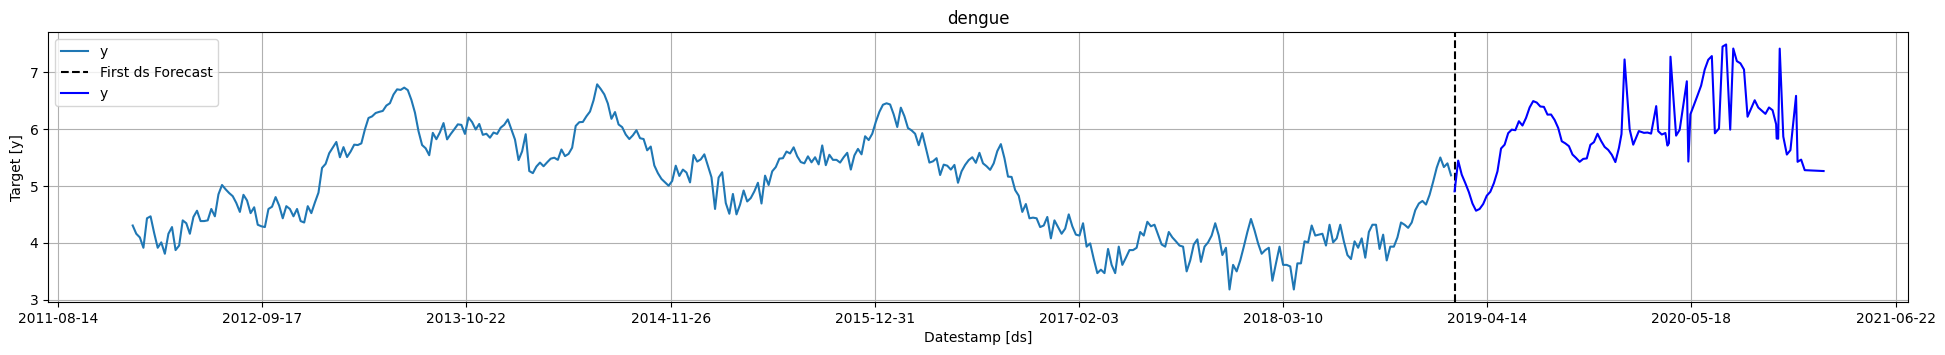

In [7]:
_dates = df['ds'].unique()
_dtrain = _dates[:-100]
_dtest = _dates[-100:]
y_train = df.query('ds in @_dtrain')
y_test = df.query('ds in @_dtest') 

StatsForecast.plot(y_train, y_test)

In [16]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)


sf = StatsForecast(
    models = [AutoTheta(season_length = 52), 
              AutoARIMA(season_length = 52),
              HistoricAverage(),
              SeasonalNaive(season_length=52)],
    freq = 'W',
    n_jobs=-1
)

sf.fit(y_train.dropna())

StatsForecast(models=[AutoTheta,AutoARIMA,HistoricAverage,SeasonalNaive])

In [17]:
forecast_df = sf.predict(h=3*52, level=[90]) 
forecast_df.tail()

,ds,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,
dengue,2021-12-26,5.231468,1.939484,8.127878,5.22488,1.782405,8.667356,4.978955,3.558823,6.399086,5.323010,2.334006,8.312014
dengue,2022-01-02,5.231468,1.867625,8.112371,5.22488,1.771130,8.678631,4.978955,3.558823,6.399086,5.501258,2.512255,8.490262
dengue,2022-01-09,5.231468,2.254511,8.173277,5.22488,1.759891,8.689870,4.978955,3.558823,6.399086,5.332719,2.343715,8.321723
dengue,2022-01-16,5.231468,2.156114,8.360484,5.22488,1.748689,8.701072,4.978955,3.558823,6.399086,5.398163,2.409159,8.387167
dengue,2022-01-23,5.231468,2.170588,8.206987,5.22488,1.737522,8.712238,4.978955,3.558823,6.399086,5.187386,2.198382,8.176390


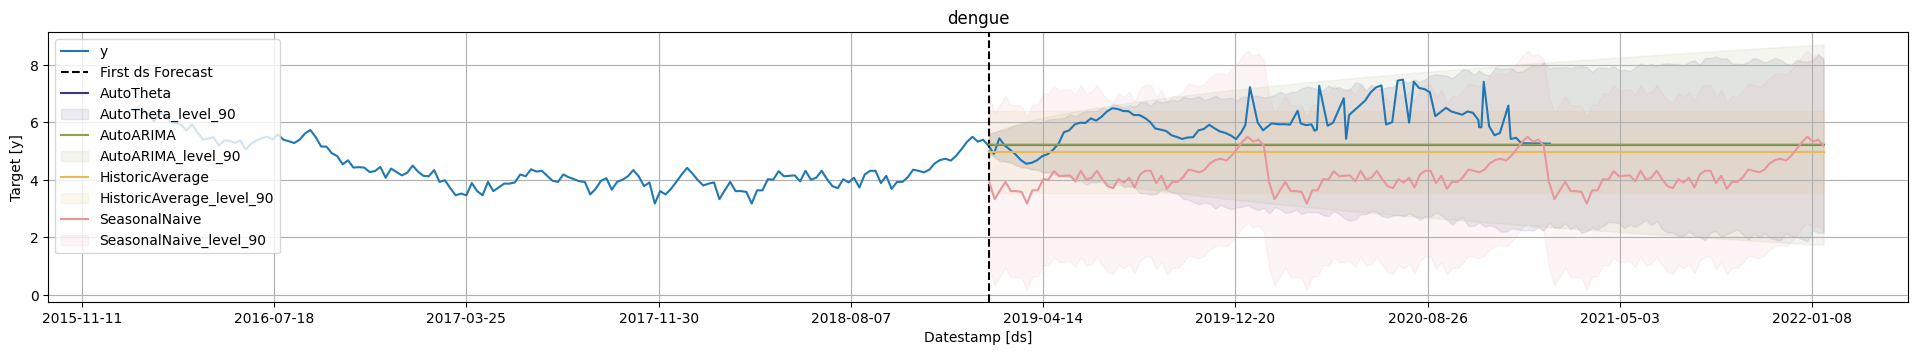

In [18]:
sf.plot(df, forecast_df, level=[90], max_insample_length=52*5)

In [11]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=52),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=52),
    HistoricAverage(),
    DOT(season_length=52)
]

# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=y_train, 
    models=models,
    freq='W', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=52)
)

forecasts_df = sf.forecast(h=52 * 2, level=[90])
forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,,,
dengue,2019-02-03,5.232993,4.893806,5.572181,3.912023,1.471512,6.352534,3.912023,1.471512,6.352534,3.912023,1.471512,6.352534,4.978955,3.558823,6.399086,5.231468,4.923444,5.619983
dengue,2019-02-10,5.223125,4.792202,5.654048,3.332205,0.891693,5.772716,3.332205,0.891693,5.772716,3.332205,0.891693,5.772716,4.978955,3.558823,6.399086,5.231468,4.802411,5.664679
dengue,2019-02-17,5.225260,4.710443,5.740077,3.637586,1.197075,6.078097,3.637586,1.197075,6.078097,3.637586,1.197075,6.078097,4.978955,3.558823,6.399086,5.231468,4.635789,5.722384
dengue,2019-02-24,5.224798,4.639603,5.809993,3.931826,1.491314,6.372337,3.931826,1.491314,6.372337,3.931826,1.491314,6.372337,4.978955,3.558823,6.399086,5.231468,4.654860,5.742774
dengue,2019-03-03,5.224898,4.576604,5.873192,3.610918,1.170407,6.051429,3.610918,1.170407,6.051429,3.610918,1.170407,6.051429,4.978955,3.558823,6.399086,5.231468,4.620784,5.845659


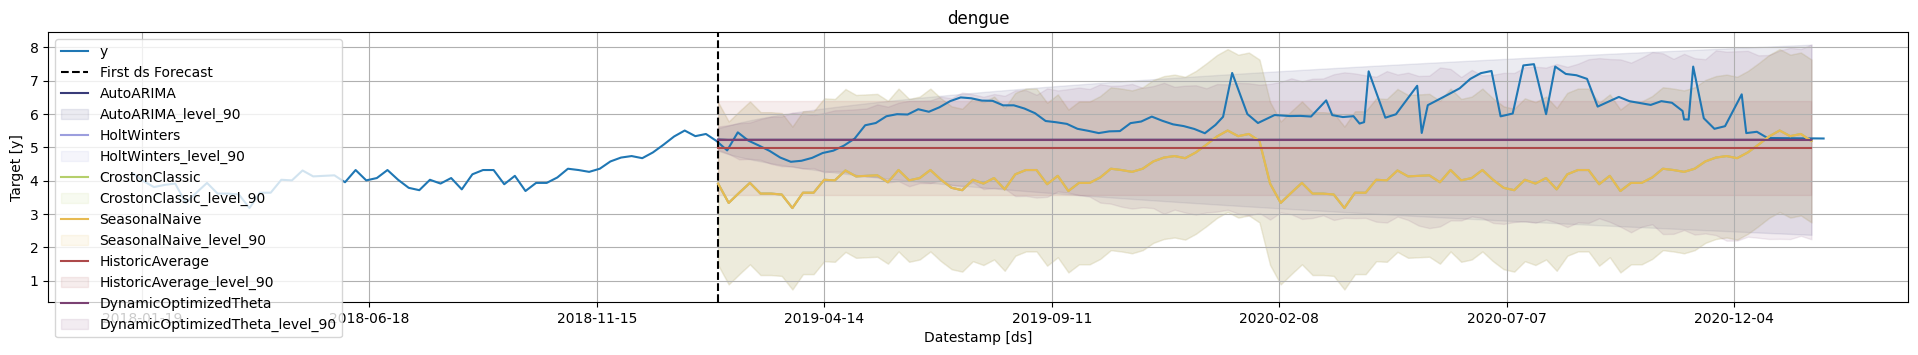

In [12]:
sf.plot(df, forecasts_df, max_insample_length=52 * 3)